In [14]:
#pip install networkx

In [15]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import networkx as nx
from main import get_data

In [16]:
# Load data
#with open("wikivital_mathematics.json") as f:
#    data = json.load(f)
data = get_data()

In [17]:
# Print 10 of the keys 
keys = list(data.keys())
print(keys[:10])

['edges', 'weights', 'node_ids', 'time_periods', '0', '1', '2', '3', '4', '5']


In [18]:
# Print 10 node_ids (page name and ID) in ascending order
sorted_node_ids = sorted(data['node_ids'].items(), key=lambda x: x[1])
for i in range(10):
    print(sorted_node_ids[i])

('Mathematics', 0)
('Number theory', 1)
('Algebra', 2)
('Geometry', 3)
('Calculus', 4)
('Mathematical analysis', 5)
('Conjecture', 6)
('Mathematical proof', 7)
('Counting', 8)
('Shape', 9)


The dataset contains information about the number of visits to 1068 pages of the English Wikipedia, as well as the relationships between them. The data is divided into 731 time periods, each of which contains the number of visits to each page on a given day. The dataset also contains information about the relationships between the pages, which are represented as a graph. 

The dataset is stored in a dictionary with the following keys:

* `edges`: a list of pairs (lists) that show links between pages. For example, [0, 1] indicates that there is a link from "Mathematics" (has an ID of 0) to "Number theory" (has an ID of 1)
* `weight`: a list of integers that show the number of times a page appears in another. For example, if the weight of the link from "Mathematics" to "Number theory" is 3, the "Mathematics" Wiki page has 3 links to the "Number theory" page. 
* `time_periods`: the number of time periods considered in the dataset (data was collected over a span of 731 days).
* `node_ids`: maps the ID of a page to its name. For example, `"Mathematics" 0` means the "Mathematics" page uses the ID 0.
* `0`, `1`, ..., `730`: daily visits data for each of the 731 days that the data was collected. Each has a dictionary with the following keys:
  * `year`: the year of data collection
  * `month`: the month of data collection
  * `day`: the day of data collection
  * `y`: the page's visit counts for each of the 1068 `node_ids`. For example, `"y":[100, 20, ...]` means that the "Mathematics" page (with ID 0) had 100 visits on that day, the second page (with ID 1) had 20 visits, etc.

# EDA

* Exploring the edges and checking how many outgoing links each page has.
* Analyzing the weights.
* Time series analysis of the visits to the pages.

----------------
**Terms/Metrics Important to PageRank:**

* In-degree: The number of incoming links to a page.
* Out-degree: The number of outgoing links from a page.
* Betweenness centrality: The number of shortest paths that pass through a node.
* Eigenvector centrality: A measure of the influence of a node in a network.
* Closeness centrality: A measure of how close a node is to all other nodes in a network.
* Clustering coefficient: A measure of the degree to which nodes in a graph cluster together.

------


In [19]:
# Extract keys for closer analysis
edges = data['edges']
node_ids = data['node_ids']
weights = data['weights']

In [20]:
# How many edges there are
len(edges)

27079

There are 27,079 edges, which tells us that there are 27,079 links between the 1,068 pages. The average number of outgoing links per page is 25.36, which means that each page has an average of 25.36 links to other pages. 

## In-degree and out-degree of the pages

Which pages have the most outgoing links? Which pages have the most incoming links?

* In other words, which pages serve as major sources of information and which pages are key destinations?

In [21]:
# Counts of out-degrees and in-degrees
out_degrees = Counter(edge[0] for edge in edges)
in_degrees = Counter(edge[1] for edge in edges)

print('Most common out-degrees: ', out_degrees.most_common(10))
print('Most common in-degrees: ', in_degrees.most_common(10))

Most common out-degrees:  [(0, 533), (62, 290), (70, 270), (64, 214), (56, 201), (3, 198), (4, 197), (45, 197), (63, 186), (5, 184)]
Most common in-degrees:  [(510, 101), (796, 99), (600, 89), (780, 89), (302, 82), (400, 82), (312, 80), (313, 80), (311, 79), (482, 79)]


This isn't very helpful without the page names, so we'll also need to map the page IDs to their names.

In [22]:
# Get node_ids in the format {ID: page name} instead of {page name: ID}
id_to_name = {v: k for k, v in node_ids.items()}

# Convert node IDs in the degree counts to page names
out_degrees_with_names = {id_to_name[node_id]: count for node_id, count in out_degrees.items()}
in_degrees_with_names = {id_to_name[node_id]: count for node_id, count in in_degrees.items()}

# Pages with most DISTINCT links leading to other pages (out-degree) and
# pages with most other DISTINCT pages linking to them links (in-degrees)
print("Pages with highest unweighted out-degrees:")
for page, degree in Counter(out_degrees_with_names).most_common(10):
    print('\t', page, ': ', degree)

print("\nPages with highest unweighted in-degrees:")
for page, degree in Counter(in_degrees_with_names).most_common(10):
    print('\t', page, ': ', degree)

Pages with highest unweighted out-degrees:
	 Mathematics :  533
	 Real number :  290
	 Function (mathematics) :  270
	 Complex number :  214
	 Integer :  201
	 Geometry :  198
	 Calculus :  197
	 Set (mathematics) :  197
	 Continuous function :  186
	 Mathematical analysis :  184

Pages with highest unweighted in-degrees:
	 Logarithm :  101
	 Eigenvalues and eigenvectors :  99
	 Bijection :  89
	 Laplace transform :  89
	 Factorial :  82
	 Domain of a function :  82
	 Exponential function :  80
	 Natural logarithm :  80
	 Differential form :  79
	 Exponentiation :  79


The **out-degree** list consists of very broad and fundamental math topics. These probably serve as overview pages that guide people to more specific topics. These pages would probably be good starting points for people to learn about a math topic becasue they give you many pathways to explore further.

The **in-degree** list consists of more specific topics. These are probably concepts that are foundational or critical enough that many other pages build upon them or require an understanding of them. They are like prerequisites for other topics.

### Weighted In- and Out-Degrees

**The unweighted in- and out-degrees tell us the number of DISTINCT links to and from a page.** So, if the out-degrees of page 0 is 500, that means there are 500 links on page 0 that go to 500 different pages. It does NOT tell us how many times it links to each one though; it just simply counts the presence of a connection.

**The weights tell us the TOTAL number of links. It includes multiple links to the same page.** So, if the weighted out-degree of page 0 is 600, that means there are 600 TOTAL links on page 0 (that could mean it links to one page 600 times, or 600 different pages once, or some combination of the two).

In [23]:
# Initialize counters for weighted degrees
weighted_out_degrees = defaultdict(float)
weighted_in_degrees = defaultdict(float)

# Sum up weights for in-degrees and out-degrees
'''
E.g., 
in `edges` we have [0,1], [0,2], [0,3]
in `weights` we have 1, 4, 2

weighted out-degrees: all edges start from 0 so we sum all weights for outgoing links
    so weighted out-degree for 0 = 1+4+2 = 7

weighted in-degrees: 
    weighted out-degree for 1 = 1 (1 link from ID0)
    weighted out-degree for 2 = 4 (4 links from ID0)
    weighted out-degree for 3 = 2 (2 links from ID0)
'''
for (page_a, page_b), weight in zip(edges, weights):
    weighted_out_degrees[page_a] += weight
    weighted_in_degrees[page_b] += weight

# Convert node_ids to page names instead of IDs
weighted_out_degrees_with_names = {id_to_name[node_id]: weight for node_id, weight in weighted_out_degrees.items()}
weighted_in_degrees_with_names = {id_to_name[node_id]: weight for node_id, weight in weighted_in_degrees.items()}

# Top weighted in- and out-degrees
print("Pages with highest weighted out-degrees:")
for page, weight in sorted(weighted_out_degrees_with_names.items(), key=lambda item: item[1], reverse=True)[:10]:
    print('\t', page, ': ', weight)

print("\nPages with highest weighted in-degrees:")
for page, weight in sorted(weighted_in_degrees_with_names.items(), key=lambda item: item[1], reverse=True)[:10]:
    print('\t', page, ': ', weight)


Pages with highest weighted out-degrees:
	 Mathematics :  654.0
	 Real number :  470.0
	 Function (mathematics) :  392.0
	 Set (mathematics) :  367.0
	 Continuous function :  330.0
	 Complex number :  324.0
	 Calculus :  314.0
	 Integer :  308.0
	 Vector space :  290.0
	 Field (mathematics) :  280.0

Pages with highest weighted in-degrees:
	 Logarithm :  143.0
	 Bijection :  131.0
	 Eigenvalues and eigenvectors :  128.0
	 Exponentiation :  121.0
	 Euclidean space :  117.0
	 Number :  115.0
	 Line integral :  115.0
	 Function of several real variables :  115.0
	 Partial derivative :  113.0
	 General topology :  113.0


When we look at the top 10 pages with the highest weighted out-degrees, we don't see a major change compared to the unweighted out-degrees. This list still consists of very broad and fundamental math topics.

However, we see more of a change in the weighted in-degrees compared to the unweighted ones. Outside of the top 3 in this list, the rest of the list is different.

## Weight Analysis

* The weight of a link is the number of times a page links to another page.

Min weight: 1
Max weight: 16
Average weight: 1.3993500498541305
Median weight: 1.0


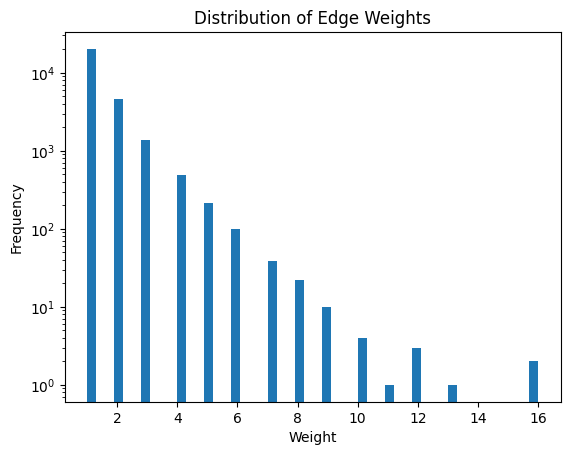

In [24]:
# Summary statistics
print("Min weight:", min(weights))
print("Max weight:", max(weights))
print("Average weight:", np.mean(weights))
print("Median weight:", np.median(weights))

# Plot weight distribution
plt.hist(weights, bins=50, log=True)  # log scale for better visibility
plt.title('Distribution of Edge Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()


In [25]:
# Page connections with highest weights
# (has most links in them leading to other pages)

# Combine edges and weights 
edges_with_weights = list(zip(edges, weights))

# Sort the pairs by weight
edges_with_weights_sorted = sorted(edges_with_weights, key=lambda x: x[1], reverse=True)
#edges_with_weights_sorted

# Convert page IDs to page names (using `id_to_name` above)
edges_with_names_and_weights = [(id_to_name[edge[0][0]], id_to_name[edge[0][1]], edge[1]) for edge in edges_with_weights_sorted]
#edges_with_names_and_weights

# Print top connections by weight
print('Page connections with most links:')
for a, b, weight in edges_with_names_and_weights[:10]:
    print('\t', a, ' -> ', b, ': ', weight)

Page connections with most links:
	 Tetrahedron  ->  Octahedron :  16
	 Tetrahedron  ->  5-cell :  16
	 Continuous function  ->  Taylor's theorem :  13
	 Field (mathematics)  ->  Ring (mathematics) :  12
	 Topological space  ->  General topology :  12
	 Octahedron  ->  24-cell :  12
	 Tetrahedron  ->  Regular icosahedron :  11
	 Theoretical computer science  ->  Algorithm :  10
	 Cube  ->  Octahedron :  10
	 Equilateral triangle  ->  Hexagon :  10


## Betweenness Centrality

https://towardsdatascience.com/graph-analytics-introduction-and-concepts-of-centrality-8f5543b55de3 

* This will tell us which pages are most important in connecting other pages.

The pages with high betweenness centrality scores are the pages that are most important in connecting other pages. These pages are like bridges that connect different parts of the network. If these pages were removed, it would be harder for information to flow between different parts of the network.

A page with a high betweenness centrality score is one that is often on the shortest path between other pages. This means that if you were to pick two random pages in the network, there is a high chance that the shortest path between them would pass through this page.
* That makes these very important (but only in terms of connecting other pages, not necessarily overall importance).

In [26]:
# Make a graph
G = nx.DiGraph()

'''
If using an UNWEIGHTED graph:

    If the number of links on page `a` that goes to `b` is not important,
    all connections are treated equally.
'''
# # UNWEIGHTED graph - add edges only
# G.add_edges_from(edges)
# # Compute betweenness for UNWEIGHTED graph:
# betweenness = nx.betweenness_centrality(G, weight='weight')

'''
If using a WEIGHTED graph:

    If the number of links on page `a` that goes to `b` is important.
    Paths with less links as "shorter" or "easier" to traverse
'''
# WEIGHTED graph - add edges and weights
for edge, weight in zip(edges, weights):
    G.add_edge(edge[0], edge[1], weight=weight)


In [27]:
# Compute betweenness for WEIGHTED graph
betweenness = nx.betweenness_centrality(G, weight='weight')

# Sort the scores
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)

# Convert node IDs to page names
betweenness_with_names = [(id_to_name[node_id], count) for node_id , count in sorted_betweenness]

print('Pages with highest betweenness centrality:')
for page, score in betweenness_with_names[:10]:
    print('\t', page, 'page: ', score)

Pages with highest betweenness centrality:
	 Bijection page:  0.01151381639131695
	 Logarithm page:  0.011031123144553736
	 Domain of a function page:  0.008993257405928433
	 Directed graph page:  0.007727973612588293
	 Total order page:  0.006882752546486764
	 Exponentiation page:  0.0068402192163225664
	 Big O notation page:  0.006084508264464584
	 Factorial page:  0.005971530872977287
	 Absolute value page:  0.005788469166841349
	 Cartesian product page:  0.005520265858572751


These are the topics that are crucial in understanding because they link different areas of math. 

## Closeness Centrality

https://towardsdatascience.com/graph-analytics-introduction-and-concepts-of-centrality-8f5543b55de3

* This will tell us which pages are closest to all other pages in the network.

In [28]:
# Compute closeness for WEIGHTED graph
closeness = nx.closeness_centrality(G, distance='weight')

# Sort the scores
sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

# Convert node IDs to page names
closeness_with_names = [(id_to_name[node_id], count) for node_id , count in sorted_closeness]

print('Pages with highest closeness centrality:')
for page, score in closeness_with_names[:10]:
    print('\t', page, 'page: ', score)

Pages with highest closeness centrality:
	 Surjective function page:  0.25842005496307235
	 Graph homomorphism page:  0.25786837721391487
	 Constant function page:  0.25012985901893803
	 Preorder page:  0.2458037087813985
	 Bipartite graph page:  0.24273708687733198
	 Component (graph theory) page:  0.24170663306050902
	 Cycle (graph theory) page:  0.23878499092143857
	 Hypergraph page:  0.23774802784309546
	 Lambert W function page:  0.2375673805441571
	 Stirling numbers of the second kind page:  0.23514255888730043


## Eigenvector Centrality

https://towardsdatascience.com/graph-analytics-introduction-and-concepts-of-centrality-8f5543b55de3

* This will tell us which pages are most influential in the network.

In [29]:
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Sort the scores
sorted_ev = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Convert node IDs to page names
ev_centrality_with_names = [(id_to_name[node_id], count) for node_id , count in sorted_ev]

print('Pages with highest Eigenvector centrality:')
for page, score in ev_centrality_with_names[:10]:
    print('\t', page, 'page: ', score)

Pages with highest Eigenvector centrality:
	 Rotations in 4-dimensional Euclidean space page:  0.8896601493885045
	 24-cell page:  0.45162199606253056
	 120-cell page:  0.06702947471207041
	 600-cell page:  0.005427733362065099
	 Coxeter graph page:  0.003128100362879948
	 Tait's conjecture page:  0.0024483290039999718
	 Lovász conjecture page:  0.0016317152017032086
	 Herschel graph page:  0.0008514918086355966
	 5-cell page:  0.0006480343673580404
	 Hamiltonian path page:  0.0004237845094678468


This tells us which pages are most influential within the network of math topics. 

The pages with high eigenvector centrality scores are the pages that are well-connected and connected to other well-connected pages.
* Key nodes through which many paths pass through. 

"Rotations in 4-dimensional Euclidean space" is most influential by far. Then there is a significant drop in "24-cell" and an even bigger drop to the other pages.

The topics are predominantly about geometry and graph theory. 
* They're crucial hubs in the math network.

# Class Notes on PageRank

**PageRank Formula:**

$$\text{Given } G=(V,E) \text{ a directed graph with vertices } V \text{ and edges } E \\ S(V_i) = \frac{(1-d)}{N} + d \sum_{j \in In(V_i)} \frac{S(V_j)}{|Out(V_j)|} \\ \text{ where } d \text{ is the damping factor (usually 0.85), } N \text{ is the number of nodes, }  \\ In(V_i) \text{ is the set of nodes that directly link to } V_i \text{, and } Out(V_i) \text{ is the number of outgoing links from } V_j$$

**When you should stop the iteration:**

If the score of the current iteration is less than the score of the next iteration, you stop.

$$|S(V_i)^n - S(V_i)^{n-1}| - |S(V_i)^{k+1} - S(V_i)^k|$$

In [30]:
# Graph of whole dataset (27,079 edges)
# ! Dataset is too big to make this graph readable

# G = nx.DiGraph()

# for edge, weight in zip(edges, weights):
#     G.add_edge(edge[0], edge[1], weight=weight)
    
# # Position nodes using the spring layout
# pos = nx.spring_layout(G)

# # Draw the graph
# nx.draw(G, pos, with_labels=True, labels=node_ids, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')

# # Draw edge labels to show weights
# edge_labels = nx.get_edge_attributes(G, 'weight')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# # Show the plot
# plt.show()


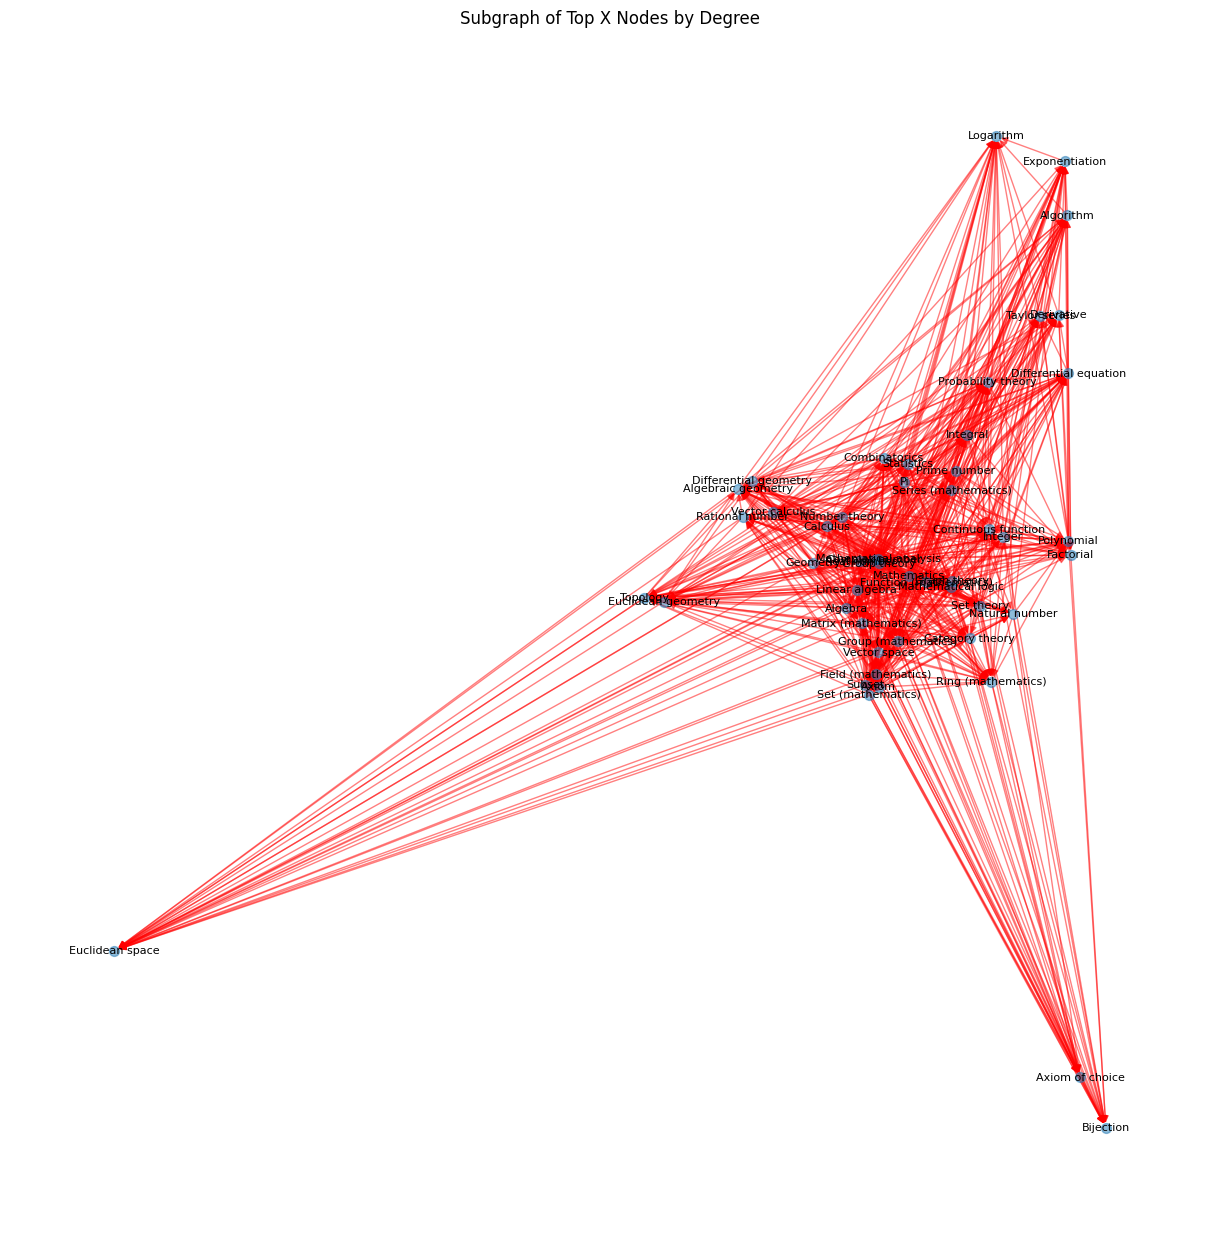

In [31]:
# Create a directed graph from your edges
G = nx.DiGraph()
G.add_edges_from(data['edges'])

# 'node_ids' is dict that maps node IDs to page names
node_labels = {node_id: page_name for page_name, node_id in data['node_ids'].items()}

# Select a subset of nodes to plot (e.g., nodes with the highest degree centrality)
degrees = dict(G.degree())
high_degree_nodes = sorted(degrees, key=degrees.get, reverse=True)[:50] # Number of nodes to plot (100 is too cluistered)
subgraph = G.subgraph(high_degree_nodes)

# Position nodes using the spring layout or another layout of your choice
pos = nx.spring_layout(subgraph)

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw(subgraph, pos, with_labels=False, node_size=50, edge_color='red', alpha=0.5)

# Draw custom labels for the subgraph
subgraph_labels = {node: node_labels[node] for node in subgraph.nodes()}
nx.draw_networkx_labels(subgraph, pos, labels=subgraph_labels, font_size=8)

plt.title('Subgraph of Top X Nodes by Degree')
plt.axis('off')  # Turn off the axis
plt.show()

